## **IMPORT LIBRARY**

In [ ]:
!pip install transformers
! pip install --upgrade scikit-learn
! pip install tqdm
! pip install wordcloud

In [ ]:
! pip install scikit-learn==0.24.2
! pip install imbalanced-learn==0.8.0


  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### **LOAD DATASET**

In [ ]:
df = pd.read_csv('Dataset_Ulasan.csv')

### **PREPROCESSING**

In [ ]:
# Menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    return text_no_emoticons

# Mengubah menjadi huruf kecil
df['content'] = df['content'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))
# Menampilkan hasil
print(df.head())

                         content  label
0             baru mulai mencoba      2
1                  qaraa mantapp      2
2                          bagus      2
3                good aplication      2
4  aplikasi bagus sangat berguna      2


### **Wordcloud**

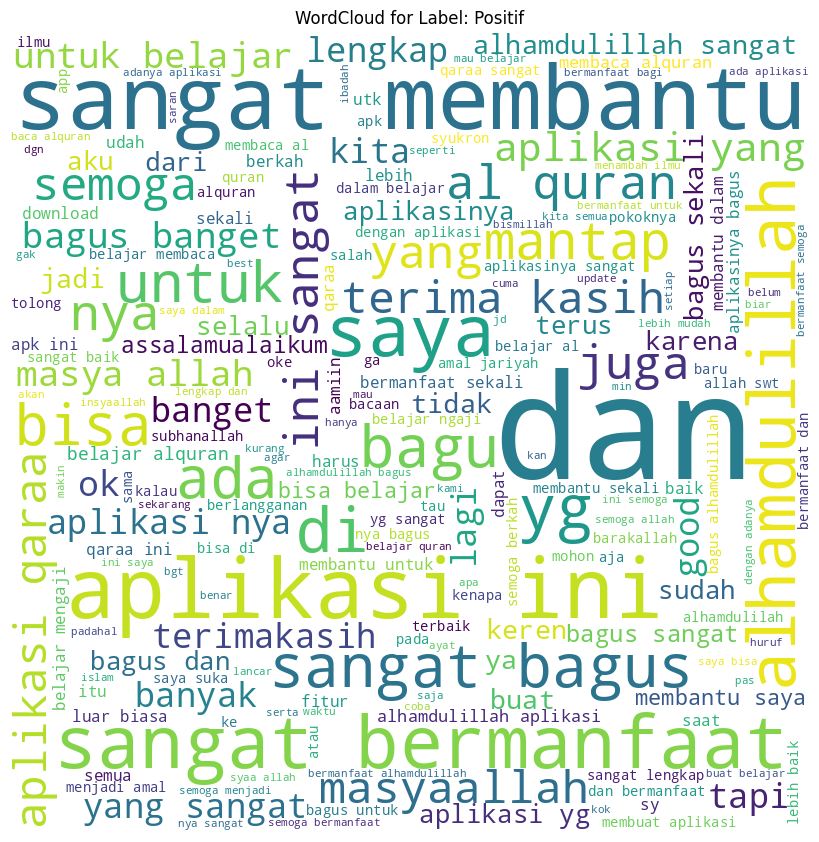

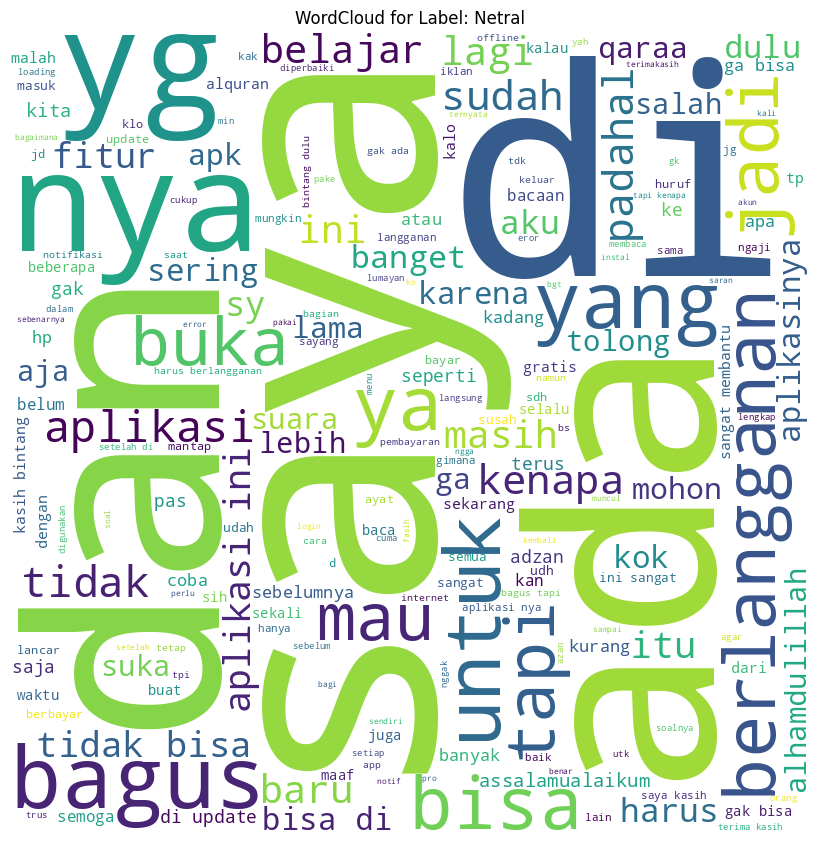

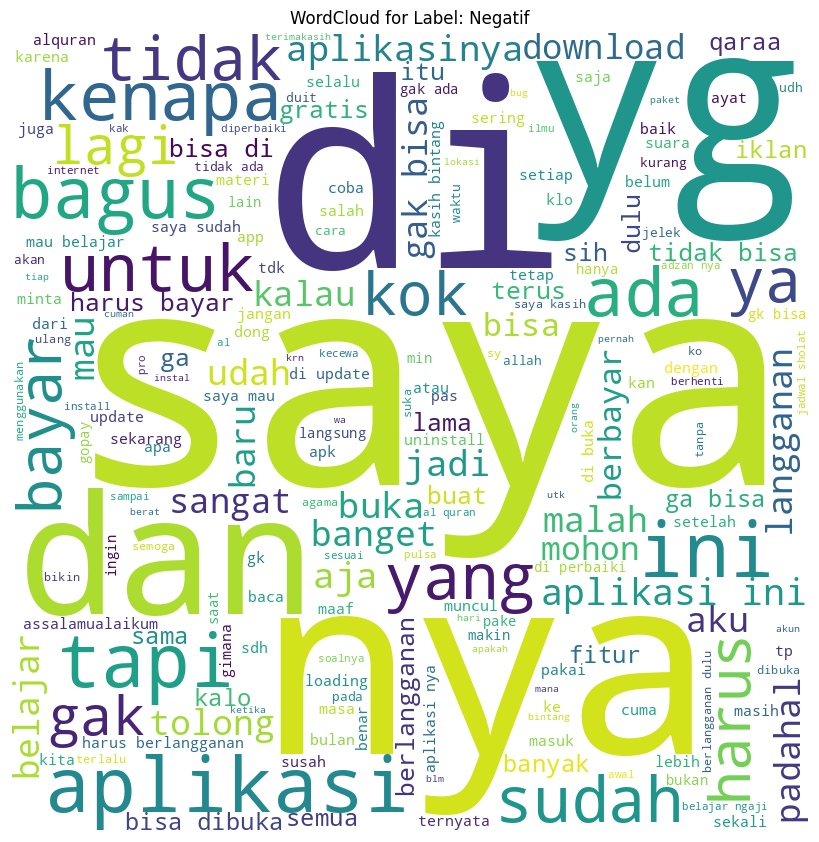

In [ ]:
# Membuat WordCloud untuk setiap Label
# Identifikasi label
label_mapping = {2: 'Positif', 1: 'Netral', 0: 'Negatif'}

labels = df['label'].unique()
for label in labels:
    text = ' '.join(df[df['label'] == label]['content'].values)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'WordCloud for Label: {label_mapping[label]}')
    plt.show()

### **TRAINING/VALIDATION SPLIT**

In [ ]:
# Bagi dataset menjadi data train (60%) dan data sisa (40%)
# X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.4, random_state=17, stratify=df.label.values)

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)


In [ ]:
# Bagi dataset menjadi data train (80%) dan data sisa (20%)
X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=17, stratify=df.label.values)

# Gunakan SMOTE pada data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 1), y_train)

# Bentuk kembali data yang telah diresample
X_train_resampled = X_train_resampled.flatten()

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)

# Tampilkan jumlah masing-masing set data
print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("Jumlah data pengujian:", len(X_test))


Jumlah data pelatihan: 7950
Jumlah data validasi: 994
Jumlah data pengujian: 994


In [ ]:
# Cetak distribusi kelas sebelum SMOTE
print("Distribusi Kelas Sebelum SMOTE:")
print(df.iloc[X_train]['label'].value_counts())

print("Jumlah Sampel Setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribusi Kelas Sebelum SMOTE:
label
2    7174
0     471
1     305
Name: count, dtype: int64
Jumlah Sampel Setelah SMOTE:
2    7174
0    7174
1    7174
Name: count, dtype: int64


In [ ]:
# Tambahkan kolom baru "data_type" untuk data test
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
# Mengelompokkan nilai kolom 'data_type' di baris yang sesuai dengan indeks X_train, X_val, dan X_test pada DataFrame

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

### **Loading Tokenizer and Encoding our Data**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
print(df.head())

                         content  label data_type
0             baru mulai mencoba      2     train
1                  qaraa mantapp      2     train
2                          bagus      2       val
3                good aplication      2     train
4  aplikasi bagus sangat berguna      2     train


In [ ]:
# Menggunakan tokenizer untuk mengkodekan data setelah SMOTE
encoded_data_train_resampled = tokenizer.batch_encode_plus(
    df.loc[X_train_resampled, 'content'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data validasi
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data uji
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Mendapatkan input_ids, attention_masks, dan labels untuk data setelah SMOTE
input_ids_train_resampled = encoded_data_train_resampled['input_ids']
attention_masks_train_resampled = encoded_data_train_resampled['attention_mask']
labels_train_resampled = torch.tensor(df.loc[X_train_resampled, 'label'].values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data validasi
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data uji
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Membuat objek TensorDataset dari fitur dan label untuk data setelah SMOTE
dataset_train_resampled = TensorDataset(input_ids_train_resampled, attention_masks_train_resampled, labels_train_resampled)

# Membuat objek TensorDataset dari fitur dan label untuk data validasi
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Membuat objek TensorDataset dari fitur dan label untuk data uji
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)


In [ ]:
len(dataset_train_resampled)

21522

In [ ]:
len(dataset_val)

994

In [ ]:
len(dataset_test)

994

### **SETTING UP BERT PRE-TRAINED MODEL**

In [ ]:
# Membuat kode unik dari kolom label

possible_labels = df.label.unique()

In [ ]:
# Mengonversi label ke kelas index

label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [ ]:
# Jumlah kelas dalam tugas klasifikasi
num_labels = len(label_dict)

# Menginisialisasi model BERT untuk klasifikasi urutan
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
params = list(model.named_parameters())  # Mendapatkan Daftar Nama Parameter

print('The BERT model has {:} different named parameters.\n'.format(len(params)))  # Mencetak Jumlah Parameter

print('=== Embedding Layer ===\n')  # Mencetak informasi tentang parameter di lapisan embedding.
for p in params[0:5]:  # Pilih hanya lima parameter pertama untuk contoh, dapat disesuaikan.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== Transformer ===\n')  # Mencetak informasi tentang parameter di lapisan transformer.
for p in params[5:]:  # Mulai dari parameter ke-6 karena BERT memiliki lapisan embedding dan transformer.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=== Transformer ===

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert

### **CREATING DATA LOADERS**
membuat objek DataLoader untuk mengatur data pelatihan dan validasi dalam bentuk batch.

In [ ]:
batch_size = 32

# DataLoader untuk data pelatihan
# DataLoader untuk data setelah SMOTE
dataloader_train_resampled = DataLoader(dataset_train_resampled,
                                        sampler=RandomSampler(dataset_train_resampled),
                                        batch_size=batch_size)

# DataLoader untuk data validasi
dataloader_validation = DataLoader(dataset_val,
                                   sampler=RandomSampler(dataset_val),
                                   batch_size=batch_size)

# DataLoader untuk data uji
dataloader_test = DataLoader(dataset_test,
                              sampler=RandomSampler(dataset_test),
                              batch_size=batch_size)

### **SETTING UP OPTIMISER AND SCHEDULER**
mempersiapkan algoritma optimasi AdamW untuk mengoptimalkan (memperbarui) parameter-parameter model selama pelatihan.

In [ ]:
optimizer = AdamW(model.parameters(), # Mendapatkan semua parameter model yang memerlukan pembaruan selama pelatihan
                  lr=1e-5, # Menentukan tingkat pembelajaran (learning rate) untuk optimizer.
                  eps=1e-8) # Menentukan epsilon (ε) atau nilai kecil yang digunakan untuk mencegah pembagian dengan nol dalam algoritma AdamW.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10

# Scheduler untuk data pelatihan
scheduler_train = get_linear_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=0,
                                                  num_training_steps=len(dataloader_train_resampled)*epochs)

# Scheduler untuk data validasi
scheduler_val = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_validation)*epochs)

# Scheduler untuk data uji
num_training_steps_test = len(dataloader_test) * epochs
scheduler_test = get_linear_schedule_with_warmup(optimizer,
                                                 num_warmup_steps=0,
                                                 num_training_steps=num_training_steps_test)


### **DEFINING OUR PERFORMANCE METRICS**

In [ ]:
# Fungsi precision_score_func digunakan untuk menghitung skor presisi (precision).
def precision_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakannya
    return precision_score(labels_flat, preds_flat, average='macro')  # Menghitung presisi dengan skala rata-rata 'macro'.

# Fungsi accuracy_score_func digunakan untuk menghitung skor akurasi (accuracy).
def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return accuracy_score(labels_flat, preds_flat)  # Menghitung akurasi.

# Fungsi recall_score_func digunakan untuk menghitung skor recall.
def recall_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return recall_score(labels_flat, preds_flat, average='macro')  # Menghitung recall dengan skala rata-rata 'macro'.

# Fungsi f1_score_func digunakan untuk menghitung skor F1-score.
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return f1_score(labels_flat, preds_flat, average='weighted')  # Menghitung F1-score dengan skala rata-rata 'weighted'.

# Fungsi-fungsi evaluasi tambahan untuk data uji (pengujian).
# Fungsi-fungsi ini serupa dengan yang sebelumnya, tetapi digunakan untuk pengujian (testing) model.
def precision_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def recall_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')

def f1_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [ ]:
def accuracy_per_class_test(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}  # Mengembalikan kamus invers dari kamus label_dict

    # Mengambil prediksi dan label dalam bentuk flat array
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels.flat):  # Iterasi melalui setiap label unik dalam labels
        # Mengambil prediksi dan label yang sesuai dengan label saat ini
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        # Mencetak akurasi per kelas
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')


### **CREATING OUR TRAINING LOOP**

In [ ]:
# Periksa ketersediaan GPU
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [ ]:
# Menentukan perangkat yang digunakan untuk melatih atau menggunakan model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
# Fungsi evaluate digunakan untuk mengevaluasi model pada data validasi.
def evaluate(dataloader_val):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_val_total = 0  # Inisialisasi total loss untuk data validasi
    predictions, true_vals = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_val:  # Loop melalui batch data validasi
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data validasi
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_val_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_val_avg = loss_val_total / len(dataloader_val)  # Menghitung rata-rata loss pada data validasi

    predictions = np.concatenate(predictions, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals = np.concatenate(true_vals, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_val_avg, predictions, true_vals  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya

# Fungsi evaluate_test digunakan untuk mengevaluasi model pada data pengujian.
def evaluate_test(dataloader_test):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_test_total = 0  # Inisialisasi total loss untuk data pengujian
    predictions_test, true_vals_test = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_test:  # Loop melalui batch data pengujian
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pengujian
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_test_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions_test.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals_test.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_test_avg = loss_test_total / len(dataloader_test)  # Menghitung rata-rata loss pada data pengujian

    predictions_test = np.concatenate(predictions_test, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals_test = np.concatenate(true_vals_test, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_test_avg, predictions_test, true_vals_test  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya


In [ ]:
training_status = []  # Inisialisasi list untuk menyimpan status pelatihan

# Inisialisasi list untuk mengumpulkan data metrik
train_losses = []
val_losses = []
test_losses = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
test_accuracy_scores = []

# Loop melalui sejumlah epoch yang ditentukan
for epoch_i in tqdm(range(0, epochs)):
    model.train()  # Model dalam mode pelatihan
    loss_train_total = 0  # Inisialisasi total loss pelatihan

    # Bar progress untuk menampilkan perkembangan pelatihan
    progress_bar = tqdm(dataloader_train_resampled, desc='Epoch {:1d}'.format(epoch_i + 1), leave=True, disable=False)

    # Loop melalui batch data pelatihan
    for batch in progress_bar:
        model.zero_grad()  # Mengatur gradien pada nol
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pelatihan
        loss = outputs[0]  # Mendapatkan loss dari hasil prediksi
        loss_train_total += loss.item()
        loss.backward()  # Menghitung gradien loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Menggunakan clipping gradient untuk mencegah gradien eksplosif
        optimizer.step()  # Melakukan optimisasi dengan langkah yang dihitung
        scheduler_train.step()  # Menggunakan scheduler_train untuk pelatihan (misalnya, penurunan suku learning rate)
        progress_bar.set_postfix({'training_loss': '{0:.2f}'.format(loss.item() / len(batch))})  # Menampilkan loss saat ini

    # Menyimpan model setiap epoch
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch_i}.model')

    tqdm.write(f'\nEpoch {epoch_i}')
    loss_train_avg = loss_train_total / len(dataloader_train_resampled)
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluasi model pada data validasi
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_precision = precision_score_func(predictions, true_vals)
    val_recall = recall_score_func(predictions, true_vals)
    val_accuracy = accuracy_score_func(predictions, true_vals)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score: {val_f1}')
    tqdm.write(f'Precision Score: {val_precision}')
    tqdm.write(f'Recall Score: {val_recall}')
    tqdm.write(f'Accuracy Score: {val_accuracy}')

    # Evaluasi model pada data uji
    test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)
    test_f1 = f1_score_func_test(test_predictions, test_true_vals)
    test_precision = precision_score_func_test(test_predictions, test_true_vals)
    test_recall = recall_score_func_test(test_predictions, test_true_vals)
    test_accuracy = accuracy_score_func_test(test_predictions, test_true_vals)

    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'Test F1 Score: {test_f1}')
    tqdm.write(f'Test Precision Score: {test_precision}')
    tqdm.write(f'Test Recall Score: {test_recall}')
    tqdm.write(f'Test Accuracy Score: {test_accuracy}')

    # Menambahkan metrik pelatihan, validasi, dan uji ke dalam list
    train_losses.append(loss_train_total / len(dataloader_train_resampled))
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    f1_scores.append(val_f1)
    precision_scores.append(val_precision)
    recall_scores.append(val_recall)
    accuracy_scores.append(val_accuracy)
    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_accuracy_scores.append(test_accuracy)

    # Menambahkan status pelatihan ke dalam daftar
    training_status.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'F1 Score': val_f1,
            'Precision Score': val_precision,
            'Recall Score': val_recall,
            'Accuracy Score': val_accuracy,
            'Test Loss': test_loss,
            'Test F1 Score': test_f1,
            'Test Precision Score': test_precision,
            'Test Recall Score': test_recall,
            'Test Accuracy Score': test_accuracy
        }
    )

  0%|          | 0/10 [11:32<?, ?it/s]


Epoch 0
Training loss: 0.12247779368274855


  0%|          | 0/10 [11:43<?, ?it/s]

Validation loss: 0.3030328133027069
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 10%|█         | 1/10 [11:52<1:46:51, 712.42s/it]

Test loss: 0.29969800915569067
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 10%|█         | 1/10 [23:23<1:46:51, 712.42s/it]


Epoch 1
Training loss: 0.1236026282180073


 10%|█         | 1/10 [23:33<1:46:51, 712.42s/it]

Validation loss: 0.3023470110274502
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 20%|██        | 2/10 [23:43<1:34:51, 711.46s/it]

Test loss: 0.2937178545325878
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 20%|██        | 2/10 [35:14<1:34:51, 711.46s/it]


Epoch 2
Training loss: 0.12276290030942408


 20%|██        | 2/10 [35:24<1:34:51, 711.46s/it]

Validation loss: 0.30429045017808676
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 30%|███       | 3/10 [35:33<1:22:58, 711.15s/it]

Test loss: 0.3075731217395514
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 30%|███       | 3/10 [47:04<1:22:58, 711.15s/it]


Epoch 3
Training loss: 0.1233984313207785


 30%|███       | 3/10 [47:15<1:22:58, 711.15s/it]

Validation loss: 0.302350023182953
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 40%|████      | 4/10 [47:24<1:11:05, 711.00s/it]

Test loss: 0.29970506276004016
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 40%|████      | 4/10 [58:50<1:11:05, 711.00s/it]


Epoch 4
Training loss: 0.12342706190738384


 40%|████      | 4/10 [59:00<1:11:05, 711.00s/it]

Validation loss: 0.34398557525128126
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 50%|█████     | 5/10 [59:10<59:05, 709.06s/it]  

Test loss: 0.29370280987950537
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 50%|█████     | 5/10 [1:10:45<59:05, 709.06s/it]


Epoch 5
Training loss: 0.12346262400357515


 50%|█████     | 5/10 [1:10:55<59:05, 709.06s/it]

Validation loss: 0.3274169723736122
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 60%|██████    | 6/10 [1:11:04<47:23, 710.87s/it]

Test loss: 0.2955081342952326
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 60%|██████    | 6/10 [1:22:34<47:23, 710.87s/it]


Epoch 6
Training loss: 0.12327318357289554


 60%|██████    | 6/10 [1:22:44<47:23, 710.87s/it]

Validation loss: 0.31376099050976336
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 70%|███████   | 7/10 [1:22:54<35:31, 710.45s/it]

Test loss: 0.38804783136583865
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



 70%|███████   | 7/10 [1:34:26<35:31, 710.45s/it]


Epoch 7
Training loss: 0.12272541930021671


 70%|███████   | 7/10 [1:34:36<35:31, 710.45s/it]

Validation loss: 0.324347292073071
F1 Score: 0.9479455123362043
Precision Score: 0.748564541612652
Recall Score: 0.9647682448946848
Accuracy Score: 0.9416498993963782


 80%|████████  | 8/10 [1:34:46<23:41, 710.88s/it]

Test loss: 0.2936992820850719
Test F1 Score: 0.9491536846375774
Test Precision Score: 0.7561208547050015
Test Recall Score: 0.9549552461354812
Test Accuracy Score: 0.9436619718309859



Epoch 9:  92%|█████████▏| 622/673 [10:32<00:51,  1.02s/it, training_loss=0.06]

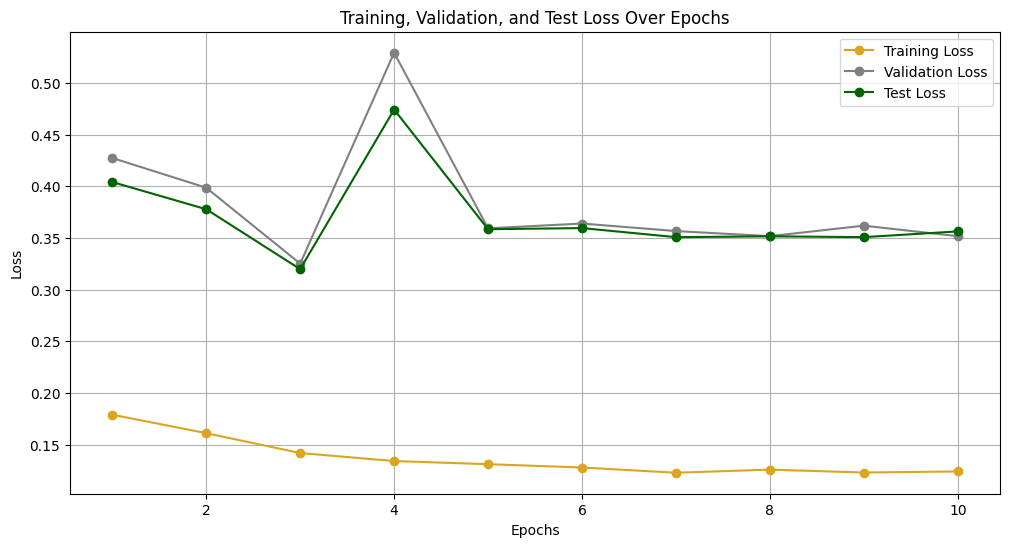

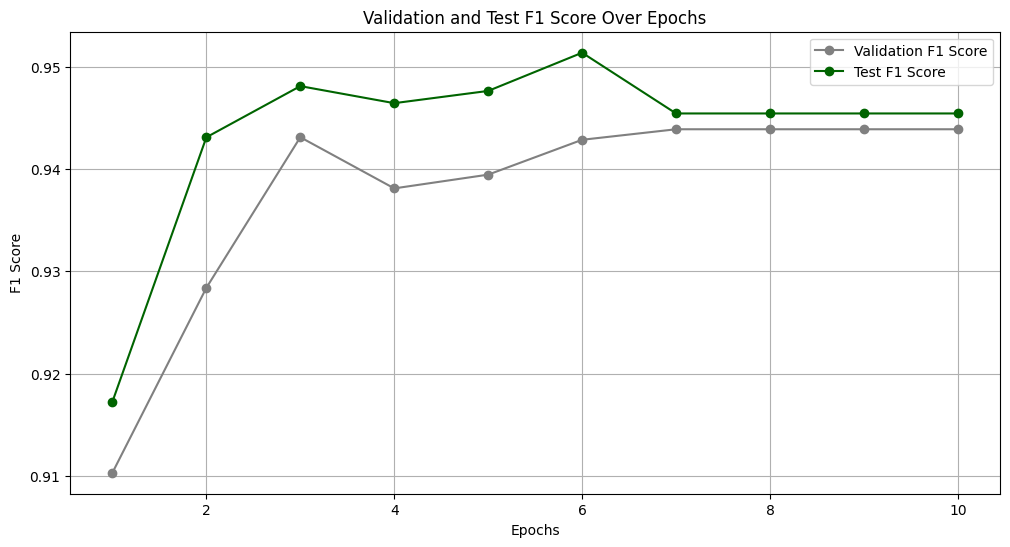

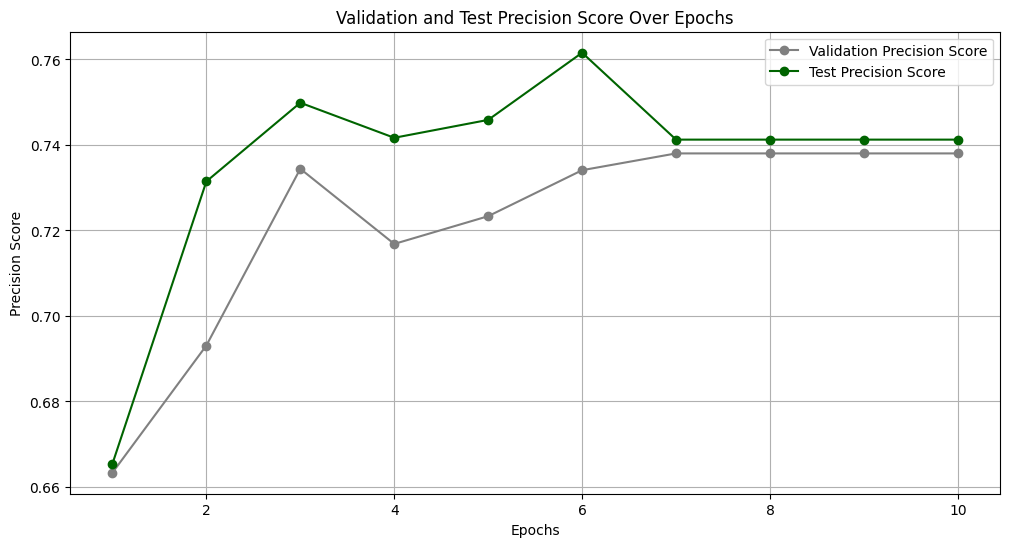

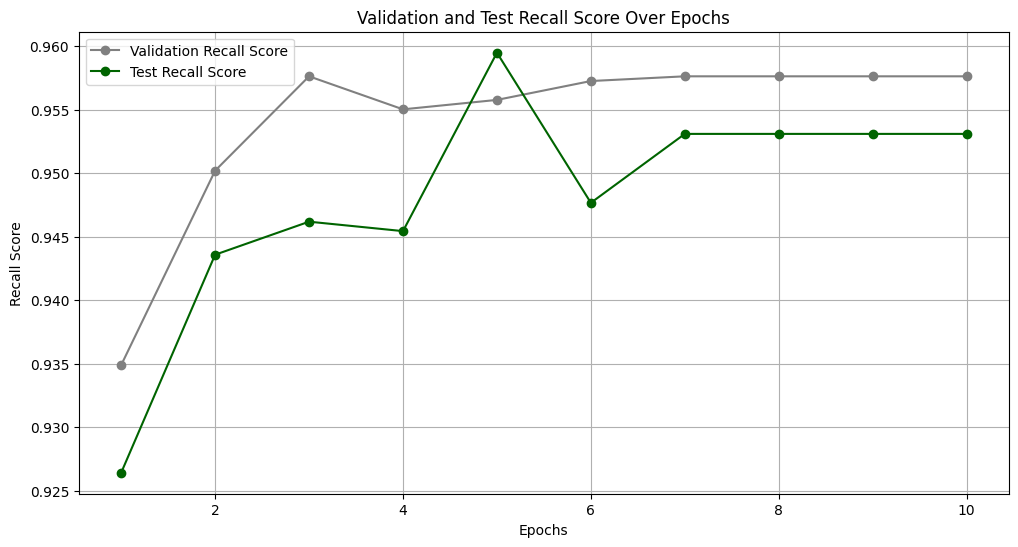

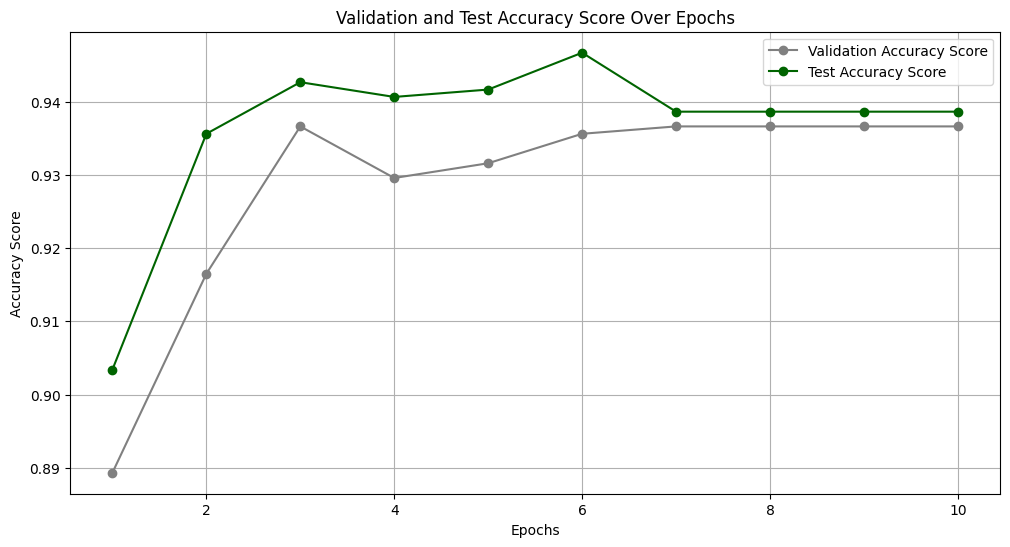

In [ ]:
import matplotlib.pyplot as plt

# Menggunakan range(1, len(train_losses) + 1) untuk sumbu x
epochs = range(1, len(train_losses) + 1)

# Warna yang konsisten
colors = {
    'Training': 'goldenRod',
    'Validation': 'Gray',
    'Test': 'DarkGreen'
}

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color=colors['Training'])
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color=colors['Validation'])
plt.plot(epochs, test_losses, label='Test Loss', marker='o', color=colors['Test'])
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, f1_scores, label='Validation F1 Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color=colors['Test'])
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_scores, label='Validation Precision Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_precision_scores, label='Test Precision Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, recall_scores, label='Validation Recall Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_recall_scores, label='Test Recall Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_scores, label='Validation Accuracy Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_accuracy_scores, label='Test Accuracy Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Menggunakan training_status yang sudah ada untuk hasil evaluasi
results = []
for epoch_result in training_status:
    epoch_metrics = {
        'Epoch': epoch_result['epoch'],
        'Training Loss': epoch_result['Training Loss'],
        'Validation Loss': epoch_result['Valid. Loss'],
        'F1 Score (Val)': epoch_result['F1 Score'],
        'Precision Score (Val)': epoch_result['Precision Score'],
        'Recall Score (Val)': epoch_result['Recall Score'],
        'Accuracy Score (Val)': epoch_result['Accuracy Score'],
        'Test Loss': epoch_result['Test Loss'],
        'Test F1 Score': epoch_result['Test F1 Score'],
        'Test Precision Score': epoch_result['Test Precision Score'],
        'Test Recall Score': epoch_result['Test Recall Score'],
        'Test Accuracy Score': epoch_result['Test Accuracy Score']
    }
    results.append(epoch_metrics)

# Buat DataFrame dari hasil evaluasi
df = pd.DataFrame(results)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  F1 Score (Val)  \
0      1       0.179063         0.427476        0.910299   
1      2       0.161155         0.398686        0.928384   
2      3       0.141959         0.325225        0.943114   
3      4       0.134199         0.529333        0.938108   
4      5       0.131169         0.359380        0.939452   
5      6       0.127936         0.364046        0.942861   
6      7       0.122901         0.356750        0.943891   
7      8       0.125892         0.351807        0.943891   
8      9       0.123100         0.361959        0.943891   
9     10       0.124145         0.351802        0.943891   

   Precision Score (Val)  Recall Score (Val)  Accuracy Score (Val)  Test Loss  \
0               0.663333            0.934888              0.889336   0.404195   
1               0.693086            0.950200              0.916499   0.377868   
2               0.734416            0.957632              0.936620   0.319880   
3              

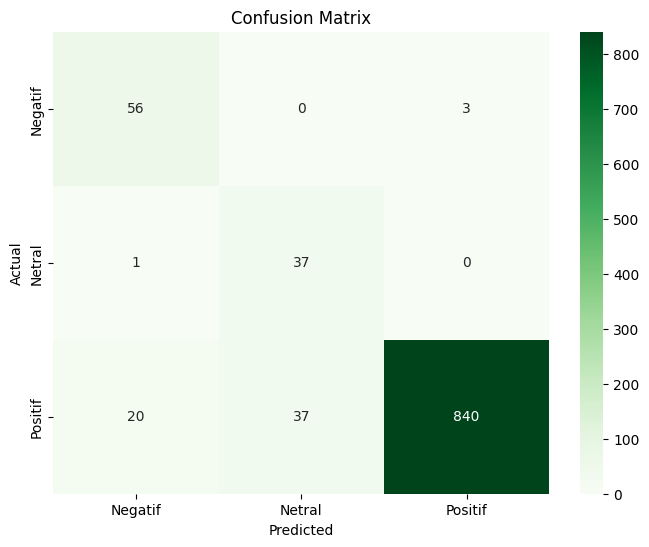

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluasi model pada data uji
test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)

# Membuat confusion matrix
confusion = confusion_matrix(test_true_vals, test_predictions.argmax(axis=1))

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix dengan palet hijau
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Set model ke mode evaluasi
model.eval()

# Inisialisasi list untuk menyimpan hasil prediksi dan label sebenarnya
all_predictions = []
all_true_vals = []

# Loop melalui batch data uji
for batch in tqdm(dataloader_test, desc='Evaluating'):
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data uji
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)  # Mengambil kelas dengan nilai probabilitas tertinggi
    all_predictions.extend(predictions.cpu().numpy())
    all_true_vals.extend(batch[2].cpu().numpy())

# Tampilkan hasil prediksi dan label yang sebenarnya
for i in range(len(all_predictions)):
    print(f'Prediksi: {all_predictions[i]}, Label Sebenarnya: {all_true_vals[i]}')


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Prediksi: 2, Label Sebenarnya: 2
Prediksi: 1, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 

In [ ]:

# Gantilah 'kalimat_anda_di_sini' dengan kalimat yang ingin Anda prediksi
kalimat = 'Uninstalling it today'
encoded_data = tokenizer.encode_plus(
    kalimat,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids'].to(device)
attention_mask = encoded_data['attention_mask'].to(device)

with torch.no_grad():
    model.eval()
    outputs = model(input_ids, attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Gantilah 'label_dict_inverse' dengan kamus invers label_dict Anda
label_dict_inverse = {v: k for k, v in label_dict.items()}
predicted_sentiment = label_dict_inverse[predictions[0]]

print(f'Kalimat: {kalimat}')
print(f'Sentimen Prediksi: {predicted_sentiment}')


Kalimat: Uninstalling it today
Sentimen Prediksi: 0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
